In [1]:
import pandas as pd
import numpy as np
import math
import re
from datetime import timedelta


In [2]:
quali_df = pd.read_csv('../../data/qualifying.csv')
quali_df

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
9090,9131,1051,8,51,7,16,1:23.156,\N,\N
9091,9132,1051,849,3,6,17,1:23.213,\N,\N
9092,9133,1051,841,51,99,18,1:23.262,\N,\N
9093,9134,1051,854,210,47,19,1:23.407,\N,\N


In [3]:
drivers_df = pd.read_csv('../../data/drivers.csv')
drivers_df['dob'] = pd.to_datetime(drivers_df['dob'])

races_df = pd.read_csv('../../data/races.csv')

In [8]:
quali_df[(quali_df['raceId'] == 18) & (quali_df['position'] == 1)]['q3'].item()

'1:26.714'

In [46]:
quali_differences_df = pd.DataFrame(columns=['driverId', 'forename', 'surname', 'difference', 'teammateId', 'teammateName','age', 'year', 'circuit'])
#quali_differences_df = pd.DataFrame(columns=['difference', 'age'])

invalid_count = 0
not_1_count = 0
null_count = 0
for index, row in quali_df.iterrows():
    race_id = row['raceId']
    constructor_id = row['constructorId']
    driver_id = row['driverId']
    teammate = quali_df[(quali_df['raceId'] == race_id) & (quali_df['constructorId'] == constructor_id) & (quali_df['driverId'] != driver_id)]
    if len(teammate) == 1:
        q = ''
        if (row['q3'] != '\\N' and teammate['q3'].item() != '\\N') and not (isinstance(row['q3'], float) or isinstance(teammate['q3'].item(), float)):
            q = 'q3'
        elif (row['q2'] != '\\N' and teammate['q2'].item() != '\\N') and not (isinstance(row['q2'], float) or isinstance(teammate['q2'].item(), float)):
            q = 'q2'
        elif (row['q1'] != '\\N' and teammate['q1'].item() != '\\N') and not (isinstance(row['q1'], float) or isinstance(teammate['q1'].item(), float)):
            q = 'q1'
        else:
            null_count +=1
        if q != '':
            pole = quali_df[(quali_df['raceId'] == race_id) & (quali_df['position'] == 1)]
            pole_time = ''
            if pole['q3'].item() != '\\N' and not (isinstance(pole['q3'].item(), float)):
                pole_time = pole['q3'].item()
            elif pole['q2'].item() != '\\N' and not (isinstance(pole['q2'].item(), float)):
                pole_time = pole['q2'].item()
            elif pole['q1'].item() != '\\N' and not (isinstance(pole['q1'].item(), float)):
                pole_time = pole['q1'].item()
            else:
                null_count += 1
            if pole_time != '':
                #pole_time = quali_df[(quali_df['raceId'] == race_id) & (quali_df['position'] == 1)]['q3'].item()
                pole_time_regex = quali_time_regex = re.match(r"(?P<m>[0-9]+):(?P<s>[0-9]+).(?P<ms>[0-9]+)", pole_time)
                pole_time_sec = timedelta(minutes=float(pole_time_regex['m']),seconds=float(pole_time_regex['s']),milliseconds=float(pole_time_regex['ms'])).total_seconds()

                quali_time_regex = re.match(r"(?P<m>[0-9]+):(?P<s>[0-9]+).(?P<ms>[0-9]+)", row[q])
                quali_time_sec = timedelta(minutes=float(quali_time_regex['m']),seconds=float(quali_time_regex['s']),milliseconds=float(quali_time_regex['ms'])).total_seconds()
                teammate_time_regex = re.match(r"(?P<m>[0-9]+):(?P<s>[0-9]+).(?P<ms>[0-9]+)", teammate[q].item())
                teammate_time_sec = timedelta(minutes=float(teammate_time_regex['m']),seconds=float(teammate_time_regex['s']),milliseconds=float(teammate_time_regex['ms'])).total_seconds()

                difference = (quali_time_sec-pole_time_sec)/pole_time_sec - (teammate_time_sec-pole_time_sec)/pole_time_sec

                teammate_id = teammate['driverId'].item()
                teammate_name = drivers_df[drivers_df['driverId'] == teammate_id]['driverRef'].item()

                forename = drivers_df[drivers_df['driverId'] == driver_id]['forename'].item()
                surname = drivers_df[drivers_df['driverId'] == driver_id]['surname'].item()
                year = races_df[races_df['raceId'] == race_id]['year'].item()
                age = year-drivers_df[drivers_df['driverId'] == driver_id]['dob'].item().year
                circuit = races_df[races_df['raceId'] == race_id]['name'].item()
                quali_differences_df = quali_differences_df.append(pd.DataFrame([[driver_id, forename, surname, difference, teammate_id, teammate_name, age, year, circuit]], columns=['driverId', 'forename', 'surname', 'difference', 'teammateId', 'teammateName','age', 'year', 'circuit']))
                #quali_differences_df = quali_differences_df.append(pd.DataFrame([[difference, age]], columns=['difference', 'age']))
                #print('asd')
        else:
            invalid_count += 1
    else:
        not_1_count +=1
        

In [47]:
quali_differences_df.reset_index(drop=True, inplace=True)
quali_diff_copy = quali_differences_df.copy()
quali_differences_df

,driverId,forename,surname,difference,teammateId,teammateName,age,year,circuit
0,1,Lewis,Hamilton,-0.004209,5,kovalainen,23,2008,Australian Grand Prix
1,9,Robert,Kubica,-0.004232,2,heidfeld,24,2008,Australian Grand Prix
2,5,Heikki,Kovalainen,0.004209,1,hamilton,27,2008,Australian Grand Prix
3,13,Felipe,Massa,-0.001684,8,raikkonen,27,2008,Australian Grand Prix
4,2,Nick,Heidfeld,0.004232,9,kubica,31,2008,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...
8805,8,Kimi,Räikkönen,-0.001311,841,giovinazzi,42,2021,Qatar Grand Prix
8806,849,Nicholas,Latifi,0.004330,847,russell,26,2021,Qatar Grand Prix
8807,841,Antonio,Giovinazzi,0.001311,8,raikkonen,28,2021,Qatar Grand Prix
8808,854,Mick,Schumacher,-0.030336,853,mazepin,22,2021,Qatar Grand Prix


array([[<AxesSubplot:title={'center':'difference'}>]], dtype=object)

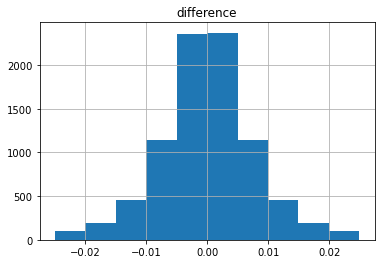

In [48]:
quali_differences_df[(quali_differences_df['difference'] > -0.025) & (quali_differences_df['difference'] <0.025)].hist()
#quali_diff_copy[(quali_diff_copy['difference'] > -2.5) & (quali_diff_copy['difference'] <2.5)].hist()

In [49]:
quali_diff_copy = quali_diff_copy[(quali_diff_copy['difference'] > -0.025) & (quali_diff_copy['difference'] <0.025)]
quali_differences_df = quali_differences_df[(quali_differences_df['difference'] > -0.025) & (quali_differences_df['difference'] <0.025)]

In [50]:
quali_differences_df

,driverId,forename,surname,difference,teammateId,teammateName,age,year,circuit
0,1,Lewis,Hamilton,-0.004209,5,kovalainen,23,2008,Australian Grand Prix
1,9,Robert,Kubica,-0.004232,2,heidfeld,24,2008,Australian Grand Prix
2,5,Heikki,Kovalainen,0.004209,1,hamilton,27,2008,Australian Grand Prix
3,13,Felipe,Massa,-0.001684,8,raikkonen,27,2008,Australian Grand Prix
4,2,Nick,Heidfeld,0.004232,9,kubica,31,2008,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...
8803,817,Daniel,Ricciardo,0.004714,846,norris,32,2021,Qatar Grand Prix
8804,847,George,Russell,-0.004330,849,latifi,23,2021,Qatar Grand Prix
8805,8,Kimi,Räikkönen,-0.001311,841,giovinazzi,42,2021,Qatar Grand Prix
8806,849,Nicholas,Latifi,0.004330,847,russell,26,2021,Qatar Grand Prix


In [51]:
quali_diff_copy

,driverId,forename,surname,difference,teammateId,teammateName,age,year,circuit
0,1,Lewis,Hamilton,-0.004209,5,kovalainen,23,2008,Australian Grand Prix
1,9,Robert,Kubica,-0.004232,2,heidfeld,24,2008,Australian Grand Prix
2,5,Heikki,Kovalainen,0.004209,1,hamilton,27,2008,Australian Grand Prix
3,13,Felipe,Massa,-0.001684,8,raikkonen,27,2008,Australian Grand Prix
4,2,Nick,Heidfeld,0.004232,9,kubica,31,2008,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...
8803,817,Daniel,Ricciardo,0.004714,846,norris,32,2021,Qatar Grand Prix
8804,847,George,Russell,-0.004330,849,latifi,23,2021,Qatar Grand Prix
8805,8,Kimi,Räikkönen,-0.001311,841,giovinazzi,42,2021,Qatar Grand Prix
8806,849,Nicholas,Latifi,0.004330,847,russell,26,2021,Qatar Grand Prix


In [52]:
driver_means = quali_differences_df.groupby('driverId').mean()
driver_means

,difference
driverId,
1,-0.001920
2,-0.000570
3,-0.001487
4,-0.003066
5,0.000311
...,...
850,0.008381
851,0.001799
852,0.007316


In [53]:
driver_medians = quali_diff_copy.groupby('driverId').median()
driver_medians

,difference
driverId,
1,-0.002035
2,-0.000173
3,-0.001246
4,-0.003135
5,0.000179
...,...
850,0.008381
851,0.001799
852,0.006700


In [54]:
for index, row in quali_differences_df.iterrows():
    driver_id = row['driverId']
    # driver id is the index in driver_means
    driver_mean = driver_means[driver_means.index == driver_id]['difference'].item()
    #print(f"{driver_id=}, ")
    quali_differences_df.at[index, 'difference'] -= driver_mean

In [55]:
for index, row in quali_diff_copy.iterrows():
    driver_id = row['driverId']
    # driver id is the index in driver_means
    driver_median = driver_medians[driver_medians.index == driver_id]['difference'].item()
    #print(f"{driver_id=}, ")
    quali_diff_copy.at[index, 'difference'] -= driver_median

In [60]:
quali_differences_df['difference'] = quali_differences_df['difference']*100 

<ipython-input-60-36f1adf5f380>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quali_differences_df['difference'] = quali_differences_df['difference']*100


In [61]:
quali_differences_df

,driverId,forename,surname,difference,teammateId,teammateName,age,year,circuit
0,1,Lewis,Hamilton,-0.228920,5,kovalainen,23,2008,Australian Grand Prix
1,9,Robert,Kubica,-0.442079,2,heidfeld,24,2008,Australian Grand Prix
2,5,Heikki,Kovalainen,0.389806,1,hamilton,27,2008,Australian Grand Prix
3,13,Felipe,Massa,-0.266973,8,raikkonen,27,2008,Australian Grand Prix
4,2,Nick,Heidfeld,0.480212,9,kubica,31,2008,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...
8803,817,Daniel,Ricciardo,0.559849,846,norris,32,2021,Qatar Grand Prix
8804,847,George,Russell,0.222467,849,latifi,23,2021,Qatar Grand Prix
8805,8,Kimi,Räikkönen,-0.151313,841,giovinazzi,42,2021,Qatar Grand Prix
8806,849,Nicholas,Latifi,-0.149545,847,russell,26,2021,Qatar Grand Prix


In [44]:
quali_diff_copy

,driverId,forename,surname,difference,teammateId,teammateName,age,year,circuit
0,1,Lewis,Hamilton,-0.002104,5,kovalainen,23,2008,Australian Grand Prix
1,9,Robert,Kubica,-0.004852,2,heidfeld,24,2008,Australian Grand Prix
2,5,Heikki,Kovalainen,0.004292,1,hamilton,27,2008,Australian Grand Prix
3,13,Felipe,Massa,-0.003308,8,raikkonen,27,2008,Australian Grand Prix
4,2,Nick,Heidfeld,0.004150,9,kubica,31,2008,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...
8805,8,Kimi,Räikkönen,-0.001629,841,giovinazzi,42,2021,Qatar Grand Prix
8806,849,Nicholas,Latifi,-0.000687,847,russell,26,2021,Qatar Grand Prix
8807,841,Antonio,Giovinazzi,0.002090,8,raikkonen,28,2021,Qatar Grand Prix
8808,854,Mick,Schumacher,-0.023455,853,mazepin,22,2021,Qatar Grand Prix


In [53]:
quali_differences_df['age'].value_counts()

26    728
23    659
28    651
25    639
24    606
27    594
30    575
29    552
31    518
22    487
32    378
35    320
34    319
33    318
21    281
36    274
37    178
20    125
38     81
41     57
39     52
19     48
40     41
42     36
43     19
18     16
Name: age, dtype: int64

In [54]:
quali_differences_df[quali_differences_df['age'] == 27].mean()

driverId       334.198653
difference      -0.157706
teammateId     240.525253
age             27.000000
year          2009.454545
dtype: float64

In [55]:
quali_differences_df[quali_differences_df['age'] == 31].mean()

driverId       147.654440
difference       0.022234
teammateId     218.959459
age             31.000000
year          2008.299228
dtype: float64

<AxesSubplot:title={'center':'difference'}, xlabel='age'>

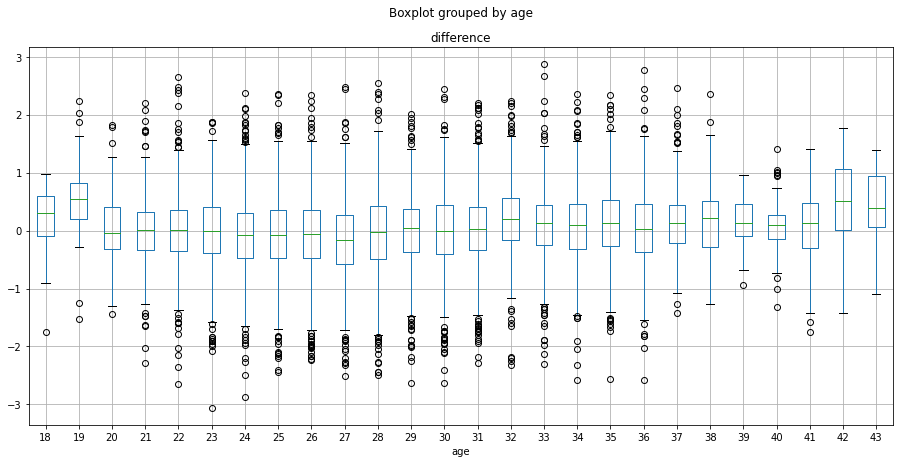

In [62]:
quali_differences_df.boxplot(column='difference', by='age', figsize=(15,7))

<AxesSubplot:title={'center':'difference'}, xlabel='age'>

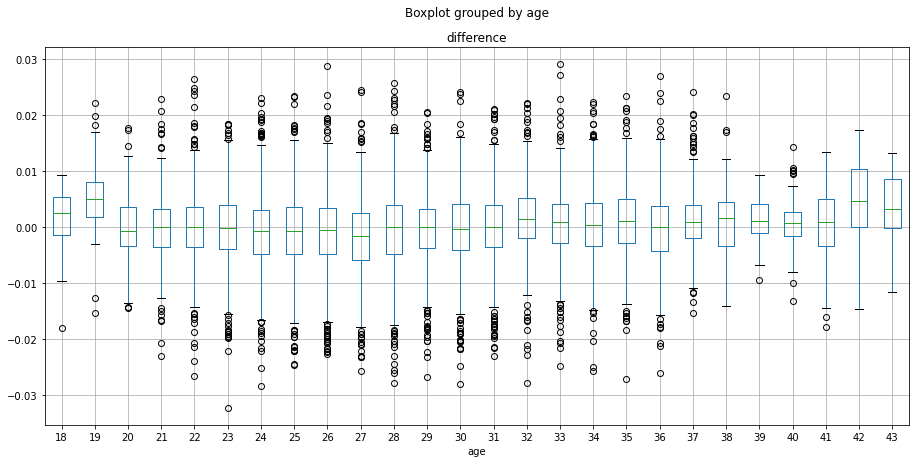

In [59]:
quali_diff_copy.boxplot(column='difference', by='age', figsize=(15,7))

In [63]:
quali_differences_df.to_csv('../../data/quali_differences_percent.csv',index=False)

<AxesSubplot:xlabel='age', ylabel='difference'>

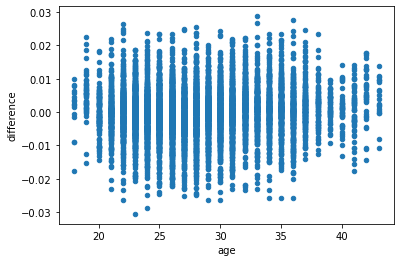

In [33]:
quali_differences_df.plot.scatter(x='age', y='difference')